# xLSTM Perplexity Evaluation Pipeline

A comprehensive, reusable pipeline for evaluating xLSTM model perplexity.

**Features:**
- Auto-detects model configuration from `config.yaml`
- Tests multiple checkpoints × context lengths
- Uses validation set for checkpoint selection, test set for final evaluation
- Generates 6 publication-ready visualizations

---

In [1]:
# ============================================================================
# CONFIGURATION - Edit this cell only
# ============================================================================

CONFIG = {
    # Model run path (REQUIRED - only input needed)
    "model_run_path": "/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/repos/helibrunna/output/xlstm_lmd_512d_2048ctx_12b/run_20260126-0516",
    
    # Evaluation settings
    "context_lengths": [1024, 2048, 3072, 4096, 5120, 10240],
    "checkpoint_selection": "auto",  # "auto", "all", or list like ["checkpoint-20000", "checkpoint-40000"]
    "auto_checkpoint_count": 6,
    
    # Output settings
    "results_base_dir": "./results",
    "save_plots": True,
    "plot_format": "png",  # "png" or "pdf"
}

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [2]:
# ============================================================================
# IMPORTS
# ============================================================================

import os
import sys
import json
import yaml
import glob
import re
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Standard tqdm (no ipywidgets needed)

import torch
from transformers import PreTrainedTokenizerFast

# Helibrunna path
HELIBRUNNA_PATH = "/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/repos/helibrunna"
if HELIBRUNNA_PATH not in sys.path:
    sys.path.insert(0, HELIBRUNNA_PATH)

from source.languagemodel import LanguageModel

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.4.1
CUDA available: True
GPU: NVIDIA RTX 6000 Ada Generation


## Phase 2: Auto-detect Model Configuration
Reads `config.yaml` from run folder to get model settings automatically.

In [3]:
def load_model_config(run_path: str) -> Dict:
    """Load and parse config.yaml from model run directory."""
    config_path = os.path.join(run_path, "config.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"config.yaml not found at {config_path}")
    
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Extract relevant fields
    model_info = {
        'model_name': config['training']['model_name'],
        'training_context_length': config['model']['context_length'],
        'embedding_dim': config['model']['embedding_dim'],
        'num_blocks': config['model']['num_blocks'],
        'vocab_size': config['model']['vocab_size'],
        'batch_size': config['training']['batch_size'],
        'learning_rate': config['training']['lr'],
        'valid_data_path': config['dataset']['local_valid'],
        'test_data_path': config['dataset']['local_test'],
        'tokenizer_path': os.path.join(run_path, 'tokenizer.json'),
    }
    return model_info

# Load and display
MODEL_INFO = load_model_config(CONFIG['model_run_path'])

print("="*60)
print("AUTO-DETECTED MODEL CONFIGURATION")
print("="*60)
for key, value in MODEL_INFO.items():
    print(f"{key:25s}: {value}")
print("="*60)

AUTO-DETECTED MODEL CONFIGURATION
model_name               : xlstm_lmd_512d_4096ctx_12b
training_context_length  : 2048
embedding_dim            : 512
num_blocks               : 12
vocab_size               : 675
batch_size               : 1
learning_rate            : 0.001
valid_data_path          : /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/lmd_preprocessed/splits/valid.txt
test_data_path           : /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/lmd_preprocessed/splits/test.txt
tokenizer_path           : /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/repos/helibrunna/output/xlstm_lmd_512d_2048ctx_12b/run_20260126-0516/tokenizer.json


## Phase 3: Checkpoint Discovery & Selection

In [4]:
def discover_checkpoints(run_path: str) -> List[Tuple[str, int]]:
    """Find all checkpoints and return as (name, step) tuples sorted by step."""
    pattern = os.path.join(run_path, "checkpoint-*")
    checkpoint_dirs = glob.glob(pattern)
    
    checkpoints = []
    for cp_dir in checkpoint_dirs:
        name = os.path.basename(cp_dir)
        match = re.search(r'checkpoint-(\d+)', name)
        if match:
            step = int(match.group(1))
            checkpoints.append((name, step))
    
    return sorted(checkpoints, key=lambda x: x[1])

def select_checkpoints(all_checkpoints: List[Tuple[str, int]], 
                       selection: str | List[str], 
                       count: int = 6) -> List[str]:
    """Select checkpoints based on selection strategy."""
    if isinstance(selection, list):
        return selection
    
    if selection == "all":
        return [cp[0] for cp in all_checkpoints]
    
    if selection == "auto":
        if len(all_checkpoints) <= count:
            return [cp[0] for cp in all_checkpoints]
        
        # Always include first and last
        selected = [all_checkpoints[0][0], all_checkpoints[-1][0]]
        
        # Select evenly spaced in between
        remaining = count - 2
        if remaining > 0:
            step = len(all_checkpoints) // (remaining + 1)
            for i in range(1, remaining + 1):
                idx = i * step
                if all_checkpoints[idx][0] not in selected:
                    selected.insert(-1, all_checkpoints[idx][0])
        
        return selected
    
    raise ValueError(f"Unknown selection strategy: {selection}")

# Discover and select
ALL_CHECKPOINTS = discover_checkpoints(CONFIG['model_run_path'])
SELECTED_CHECKPOINTS = select_checkpoints(
    ALL_CHECKPOINTS, 
    CONFIG['checkpoint_selection'], 
    CONFIG['auto_checkpoint_count']
)

print(f"Found {len(ALL_CHECKPOINTS)} checkpoints")
print(f"Selected {len(SELECTED_CHECKPOINTS)} for evaluation:")
for cp in SELECTED_CHECKPOINTS:
    print(f"  - {cp}")

Found 80 checkpoints
Selected 6 for evaluation:
  - checkpoint-2000
  - checkpoint-34000
  - checkpoint-66000
  - checkpoint-98000
  - checkpoint-130000
  - checkpoint-158760


## Phase 4: Data Loading
Load validation and test data with visualizations.

In [5]:
def load_tokenizer(tokenizer_path: str):
    """Load tokenizer from path."""
    return PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)

def load_and_tokenize_data(data_path: str, tokenizer) -> List[List[int]]:
    """Load sequences from file and tokenize."""
    sequences = []
    with open(data_path, 'r') as f:
        for line in tqdm(f, desc="Loading sequences"):
            line = line.strip()
            if line:
                tokens = tokenizer.encode(line)
                sequences.append(tokens)
    return sequences

def visualize_data_stats(sequences: List[List[int]], title: str):
    """Display data statistics with visualizations."""
    lengths = [len(seq) for seq in sequences]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram
    axes[0].hist(lengths, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Sequence Length')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'{title}: Length Distribution')
    axes[0].axvline(np.median(lengths), color='r', linestyle='--', label=f'Median: {np.median(lengths):.0f}')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(lengths, vert=True)
    axes[1].set_ylabel('Sequence Length')
    axes[1].set_title(f'{title}: Length Box Plot')
    
    # Categories pie chart
    short = sum(1 for l in lengths if l < 1024)
    medium = sum(1 for l in lengths if 1024 <= l < 4096)
    long_ = sum(1 for l in lengths if l >= 4096)
    axes[2].pie([short, medium, long_], labels=['<1024', '1024-4096', '>=4096'], 
                autopct='%1.1f%%', startangle=90)
    axes[2].set_title(f'{title}: Length Categories')
    
    plt.tight_layout()
    plt.show()
    
    # Stats table
    stats = {
        'Count': len(sequences),
        'Min Length': min(lengths),
        'Max Length': max(lengths),
        'Mean Length': f"{np.mean(lengths):.1f}",
        'Median Length': f"{np.median(lengths):.0f}",
        'Total Tokens': sum(lengths)
    }
    print(pd.DataFrame([stats]).to_string(index=False))

# Load tokenizer
print("Loading tokenizer...")
TOKENIZER = load_tokenizer(MODEL_INFO['tokenizer_path'])
print(f"Vocab size: {len(TOKENIZER)}")

Loading tokenizer...
Vocab size: 675


/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Loading VALIDATION data...


Loading sequences: 2977it [00:41, 72.33it/s]


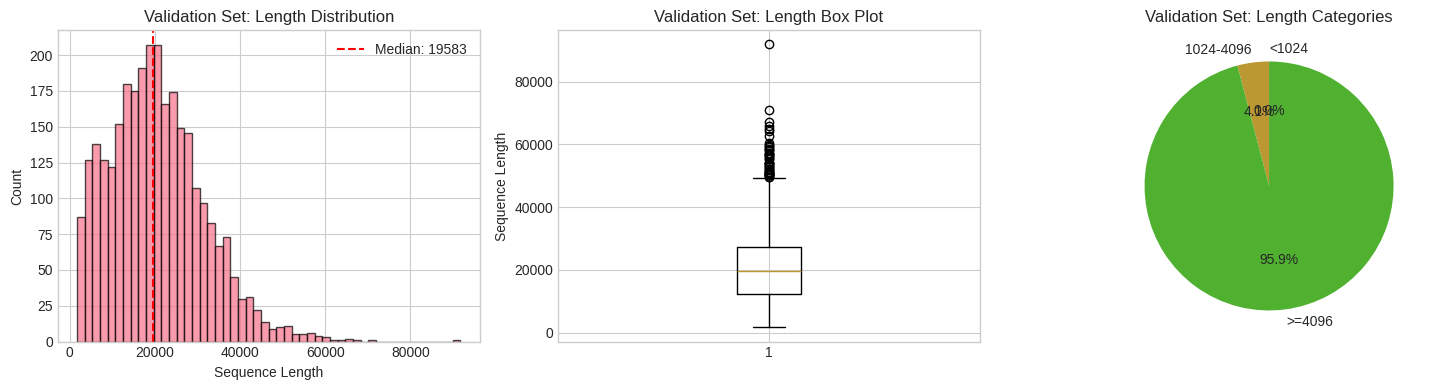

 Count  Min Length  Max Length Mean Length Median Length  Total Tokens
  2977        1676       91791     20518.2         19583      61082669


In [6]:
# Load validation data (for checkpoint selection)
print("\nLoading VALIDATION data...")
VALID_SEQUENCES = load_and_tokenize_data(MODEL_INFO['valid_data_path'], TOKENIZER)
visualize_data_stats(VALID_SEQUENCES, "Validation Set")


Loading TEST data...


Loading sequences: 2974it [00:41, 72.52it/s]


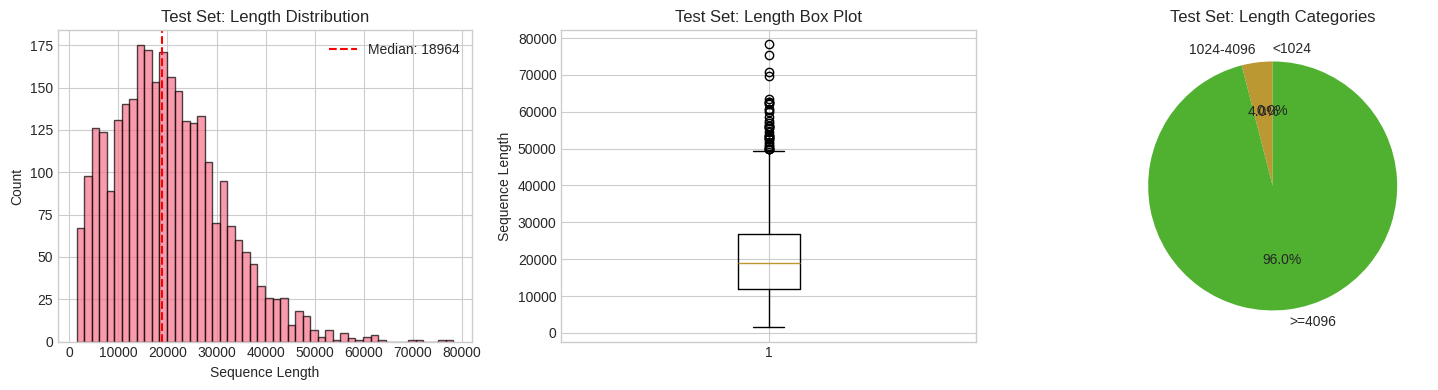

 Count  Min Length  Max Length Mean Length Median Length  Total Tokens
  2974        1488       78263     20190.2         18964      60045713


In [7]:
# Load test data (for final evaluation)
print("\nLoading TEST data...")
TEST_SEQUENCES = load_and_tokenize_data(MODEL_INFO['test_data_path'], TOKENIZER)
visualize_data_stats(TEST_SEQUENCES, "Test Set")

## Phase 5: Perplexity Computation
Core evaluation logic for computing perplexity.

In [8]:
def compute_perplexity(model, sequences: List[List[int]], context_length: int) -> float:
    """Compute perplexity on sequences at given context length."""
    total_loss = 0.0
    total_tokens = 0
    
    model.model.eval()
    with torch.no_grad():
        for seq in sequences:
            if len(seq) < 2:
                continue
            
            # Truncate to context length
            seq = seq[:context_length]
            input_ids = torch.tensor([seq[:-1]], device='cuda')
            target_ids = torch.tensor([seq[1:]], device='cuda')
            
            # Get logits
            logits = model.model(input_ids)
            
            # Compute cross-entropy loss
            loss = torch.nn.functional.cross_entropy(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1),
                reduction='sum'
            )
            
            total_loss += loss.item()
            total_tokens += len(seq) - 1
    
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity

def load_model_checkpoint(run_path: str, checkpoint_name: Optional[str] = None, 
                          context_override: Optional[int] = None) -> LanguageModel:
    """Load model with optional checkpoint and context override."""
    config_overrides = {}
    if context_override and context_override > MODEL_INFO['training_context_length']:
        config_overrides['context_length'] = context_override
    
    model = LanguageModel(
        run_path,
        device='cuda',
        checkpoint_name=checkpoint_name,
        config_overrides=config_overrides if config_overrides else None
    )
    return model

print("Perplexity computation functions defined.")

Perplexity computation functions defined.


In [9]:
def run_batch_evaluation(checkpoints: List[str], context_lengths: List[int],
                         sequences: List[List[int]], run_path: str,
                         desc: str = "Evaluation") -> pd.DataFrame:
    """Run evaluation for all checkpoint x context combinations."""
    results = []
    
    total = len(checkpoints) * len(context_lengths)
    pbar = tqdm(total=total, desc=desc)
    
    for checkpoint in checkpoints:
        # Find max context needed for this checkpoint
        max_ctx = max(context_lengths)
        
        # Load model once per checkpoint with max context override
        try:
            model = load_model_checkpoint(run_path, checkpoint, max_ctx)
        except Exception as e:
            print(f"Error loading {checkpoint}: {e}")
            continue
        
        for ctx in context_lengths:
            pbar.set_postfix({'checkpoint': checkpoint, 'context': ctx})
            try:
                ppl = compute_perplexity(model, sequences, ctx)
                results.append({
                    'checkpoint': checkpoint,
                    'step': int(re.search(r'(\d+)', checkpoint).group(1)),
                    'context_length': ctx,
                    'perplexity': ppl
                })
            except torch.cuda.OutOfMemoryError:
                print(f"OOM at {checkpoint}, context {ctx}")
                results.append({
                    'checkpoint': checkpoint,
                    'step': int(re.search(r'(\d+)', checkpoint).group(1)),
                    'context_length': ctx,
                    'perplexity': float('nan')
                })
                torch.cuda.empty_cache()
            pbar.update(1)
        
        # Free memory
        del model
        torch.cuda.empty_cache()
    
    pbar.close()
    return pd.DataFrame(results)

print("Batch evaluation function defined.")

Batch evaluation function defined.


## Phase 6: Checkpoint Selection (Training Context Only)
Evaluate all checkpoints at training context to find the best one (faster approach).

In [10]:
# Phase 6: Find best checkpoint using TRAINING CONTEXT only
# This is much faster: evaluate all checkpoints at just one context length

train_ctx = MODEL_INFO['training_context_length']
print(f"Running checkpoint selection at training context ({train_ctx})...")
print(f"Checkpoints: {len(SELECTED_CHECKPOINTS)}")
print(f"Total evaluations: {len(SELECTED_CHECKPOINTS)} (at context {train_ctx} only)")
print()

# Evaluate all checkpoints at training context ONLY
CHECKPOINT_RESULTS = run_batch_evaluation(
    SELECTED_CHECKPOINTS,
    [train_ctx],  # Only training context
    VALID_SEQUENCES,
    CONFIG['model_run_path'],
    desc="Checkpoint Selection"
)

print("\nCheckpoint results (at training context):")
display(CHECKPOINT_RESULTS.sort_values('perplexity'))


Running checkpoint selection at training context (2048)...
Checkpoints: 6
Total evaluations: 6 (at context 2048 only)



Checkpoint Selection:   0%|          | 0/6 [00:00<?, ?it/s]

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

Using /home/e20037/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/e20037/.cache/torch_extensions/py311_cu124/slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/1] /home/e20037/miniconda/envs/xlstm/bin/x86_64-conda-linux-gnu-c++ slstm.o slstm_forward.cuda.o slstm_backward.cuda.o slstm_backward_cut.cuda.o slstm_pointwise.cuda.o blas.cuda.o cuda_error.cuda.o -shared -L/home/e20037/miniconda/envs/xlstm/lib -lcublas -L/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/home/e20037/miniconda/envs/xlstm/lib -lcudart -o slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0.so


Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/e20037/miniconda/envs/xlstm/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=512', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectori

Using /home/e20037/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/e20037/miniconda/envs/xlstm/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=512', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectori

Using /home/e20037/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2165: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/home/e20037/miniconda/envs/xlstm/lib/pyth

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Checkpoint Selection:  33%|███▎      | 2/6 [06:56<13:47, 206.92s/it, checkpoint=checkpoint-34000, context=2048]

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Checkpoint Selection:  50%|█████     | 3/6 [10:16<10:11, 203.85s/it, checkpoint=checkpoint-66000, context=2048]

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Checkpoint Selection:  67%|██████▋   | 4/6 [13:36<06:44, 202.37s/it, checkpoint=checkpoint-98000, context=2048]

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Checkpoint Selection:  83%|████████▎ | 5/6 [16:50<03:19, 199.48s/it, checkpoint=checkpoint-130000, context=2048]

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Checkpoint Selection: 100%|██████████| 6/6 [20:09<00:00, 201.64s/it, checkpoint=checkpoint-158760, context=2048]


Checkpoint results (at training context):


,checkpoint,step,context_length,perplexity
2,checkpoint-66000,66000,2048,1.787322
3,checkpoint-98000,98000,2048,1.834823
1,checkpoint-34000,34000,2048,1.892572
4,checkpoint-130000,130000,2048,2.193087
5,checkpoint-158760,158760,2048,2.504637
0,checkpoint-2000,2000,2048,4.665357


In [11]:
# Find best checkpoint (lowest PPL at training context)
best_row = CHECKPOINT_RESULTS.loc[CHECKPOINT_RESULTS['perplexity'].idxmin()]
BEST_CHECKPOINT = best_row['checkpoint']
BEST_PPL = best_row['perplexity']

print("="*60)
print("BEST CHECKPOINT SELECTION")
print("="*60)
print(f"\nBest checkpoint: {BEST_CHECKPOINT}")
print(f"PPL at training context ({MODEL_INFO['training_context_length']}): {BEST_PPL:.4f}")
print("\nAll checkpoints ranked:")
display(CHECKPOINT_RESULTS.sort_values('perplexity'))


BEST CHECKPOINT SELECTION

Best checkpoint: checkpoint-66000
PPL at training context (2048): 1.7873

All checkpoints ranked:


,checkpoint,step,context_length,perplexity
2,checkpoint-66000,66000,2048,1.787322
3,checkpoint-98000,98000,2048,1.834823
1,checkpoint-34000,34000,2048,1.892572
4,checkpoint-130000,130000,2048,2.193087
5,checkpoint-158760,158760,2048,2.504637
0,checkpoint-2000,2000,2048,4.665357


## Phase 7: Final Evaluation (Test Set)
Evaluate the best checkpoint on the test set for final reporting.

In [12]:
# Phase 7: Final Evaluation on TEST set
# Evaluate best checkpoint at all context lengths

print(f"Running final evaluation of {BEST_CHECKPOINT} on TEST set...")
print(f"Context lengths: {CONFIG['context_lengths']}")
print(f"Total evaluations: {len(CONFIG['context_lengths'])}")
print()

TEST_RESULTS = run_batch_evaluation(
    [BEST_CHECKPOINT],
    CONFIG['context_lengths'],
    TEST_SEQUENCES,
    CONFIG['model_run_path'],
    desc="Test Evaluation"
)

print("\nFinal Test Results:")
display(TEST_RESULTS)


Running final evaluation of checkpoint-66000 on TEST set...
Context lengths: [1024, 2048, 3072, 4096, 5120, 10240]
Total evaluations: 6



Test Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

   ▄█    █▄       ▄████████  ▄█        ▄█  ▀█████████▄     ▄████████ ███    █▄  ███▄▄▄▄   ███▄▄▄▄      ▄████████ 
  ███    ███     ███    ███ ███       ███    ███    ███   ███    ███ ███    ███ ███▀▀▀██▄ ███▀▀▀██▄   ███    ███ 
  ███    ███     ███    █▀  ███       ███▌   ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
 ▄███▄▄▄▄███▄▄  ▄███▄▄▄     ███       ███▌  ▄███▄▄▄██▀   ▄███▄▄▄▄██▀ ███    ███ ███   ███ ███   ███   ███    ███ 
▀▀███▀▀▀▀███▀  ▀▀███▀▀▀     ███       ███▌ ▀▀███▀▀▀██▄  ▀▀███▀▀▀▀▀   ███    ███ ███   ███ ███   ███ ▀███████████ 
  ███    ███     ███    █▄  ███       ███    ███    ██▄ ▀███████████ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    ███     ███    ███ ███▌    ▄ ███    ███    ███   ███    ███ ███    ███ ███   ███ ███   ███   ███    ███ 
  ███    █▀      ██████████ █████▄▄██ █▀   ▄█████████▀    ███    ███ ████████▀   ▀█   █▀   ▀█   █▀    ███    █▀  
                            ▀                             ███    ███                    

/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/home/e20037/miniconda/envs/xlstm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2165: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected


Final Test Results:


,checkpoint,step,context_length,perplexity
0,checkpoint-66000,66000,1024,1.917821
1,checkpoint-66000,66000,2048,1.776466
2,checkpoint-66000,66000,3072,1.775449
3,checkpoint-66000,66000,4096,1.881929
4,checkpoint-66000,66000,5120,2.085391
5,checkpoint-66000,66000,10240,3.550215


## Phase 8: Visualizations
Generate 6 publication-ready charts.

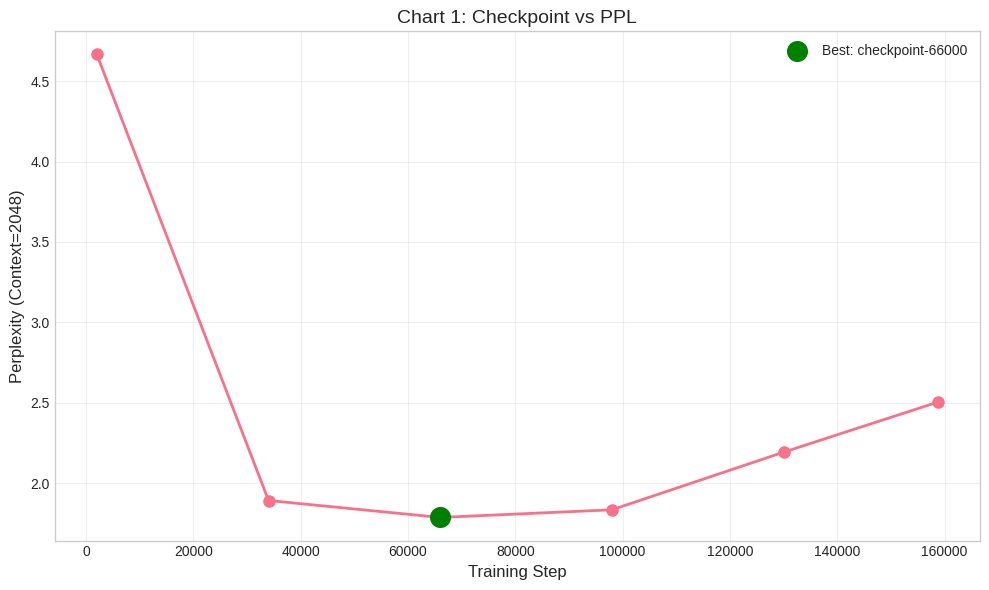

In [13]:
# Chart 1: Checkpoint vs PPL (at training context)
fig, ax = plt.subplots(figsize=(10, 6))

data = CHECKPOINT_RESULTS.sort_values('step')
ax.plot(data['step'], data['perplexity'], marker='o', linewidth=2, markersize=8)

# Mark best checkpoint
best_data = data[data['checkpoint'] == BEST_CHECKPOINT]
ax.scatter(best_data['step'], best_data['perplexity'], 
           s=200, color='green', zorder=5, label=f'Best: {BEST_CHECKPOINT}')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel(f'Perplexity (Context={MODEL_INFO["training_context_length"]})', fontsize=12)
ax.set_title(f'Chart 1: Checkpoint vs PPL', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


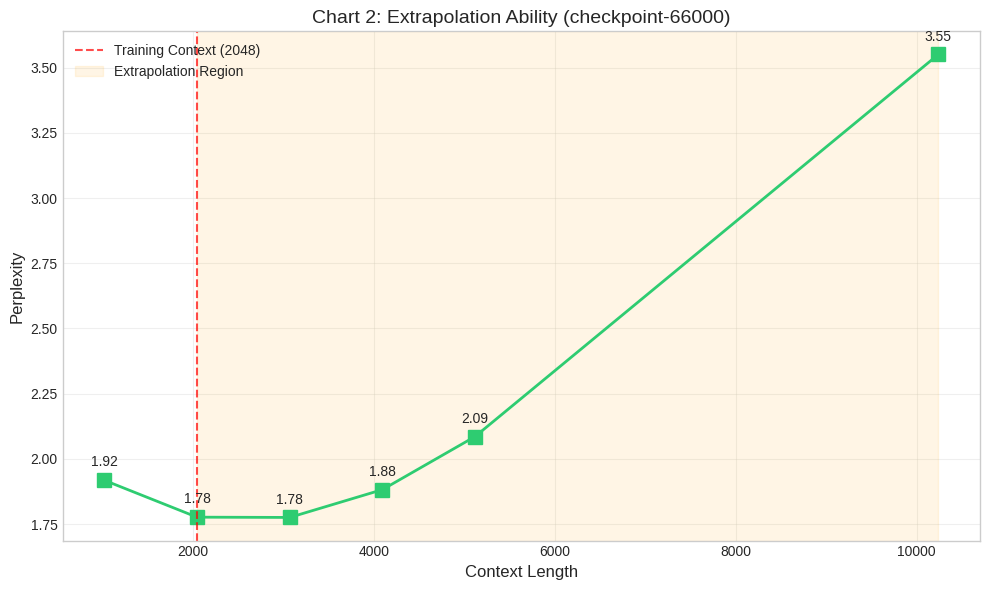

In [14]:
# Chart 2: Context Length vs PPL (Test Set)
fig, ax = plt.subplots(figsize=(10, 6))

test_data = TEST_RESULTS.sort_values('context_length')
ax.plot(test_data['context_length'], test_data['perplexity'], 
        marker='s', markersize=10, linewidth=2, color='#2ecc71')

# Mark training context
train_ctx = MODEL_INFO['training_context_length']
ax.axvline(train_ctx, color='red', linestyle='--', alpha=0.7, 
           label=f'Training Context ({train_ctx})')

# Shade extrapolation region
ax.axvspan(train_ctx, max(CONFIG['context_lengths']), alpha=0.1, color='orange',
           label='Extrapolation Region')

# Annotate points
for _, row in test_data.iterrows():
    ax.annotate(f'{row["perplexity"]:.2f}', 
                (row['context_length'], row['perplexity']),
                textcoords='offset points', xytext=(0, 10), ha='center')

ax.set_xlabel('Context Length', fontsize=12)
ax.set_ylabel('Perplexity', fontsize=12)
ax.set_title(f'Chart 2: Extrapolation Ability ({BEST_CHECKPOINT})', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


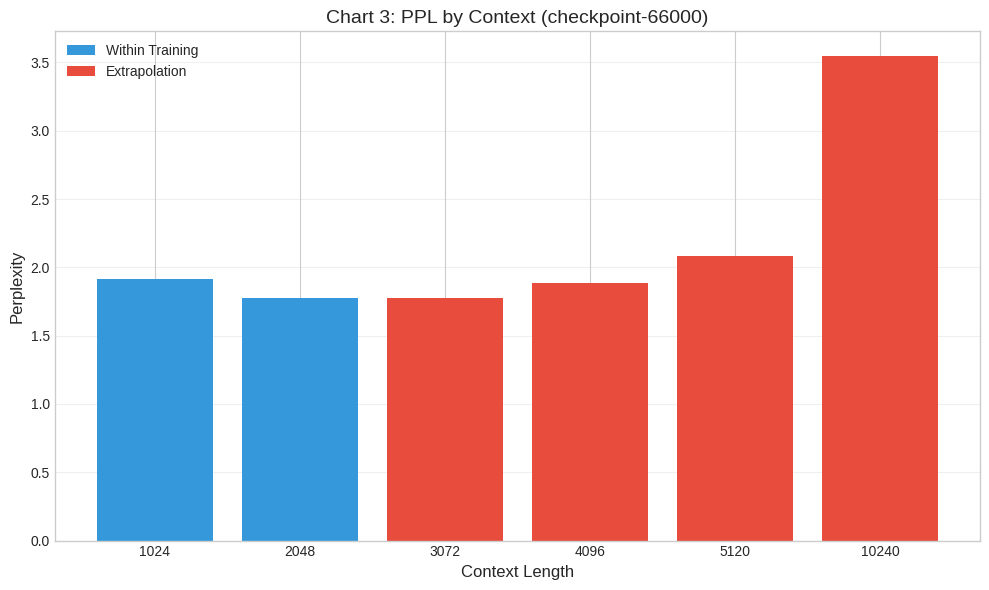

In [15]:
# Chart 3: PPL Bar Chart by Context (Test Set)
fig, ax = plt.subplots(figsize=(10, 6))

test_data = TEST_RESULTS.sort_values('context_length')
colors = ['#3498db' if ctx <= MODEL_INFO['training_context_length'] else '#e74c3c' 
          for ctx in test_data['context_length']]

bars = ax.bar(test_data['context_length'].astype(str), test_data['perplexity'], color=colors)
ax.set_xlabel('Context Length', fontsize=12)
ax.set_ylabel('Perplexity', fontsize=12)
ax.set_title(f'Chart 3: PPL by Context ({BEST_CHECKPOINT})', fontsize=14)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Within Training'),
                   Patch(facecolor='#e74c3c', label='Extrapolation')]
ax.legend(handles=legend_elements)

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


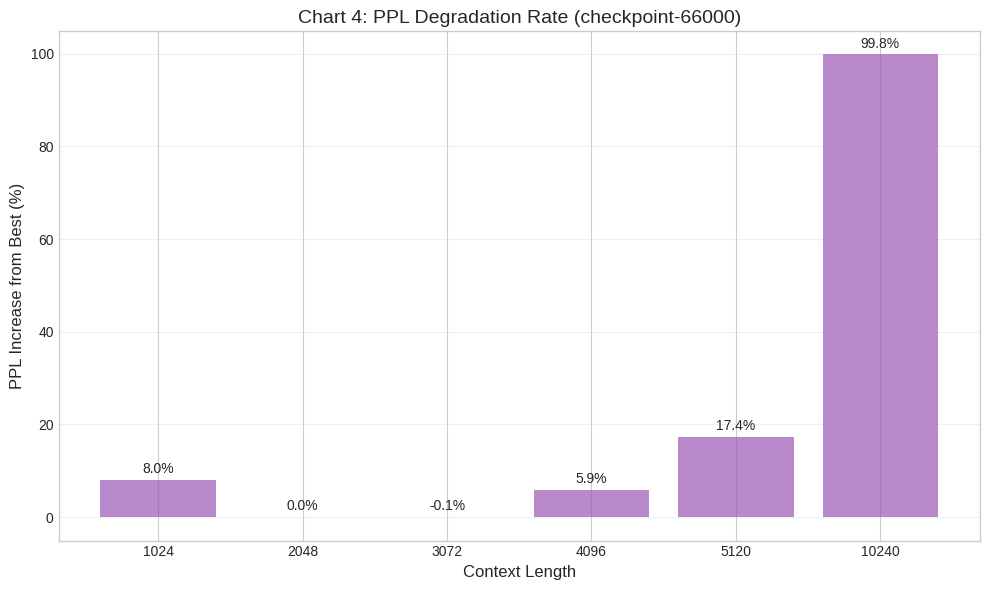

In [16]:
# Chart 4: PPL Degradation Rate
train_ctx = MODEL_INFO['training_context_length']

data = TEST_RESULTS.sort_values('context_length')
base_ppl = data[data['context_length'] <= train_ctx]['perplexity'].min()

degradation = []
for _, row in data.iterrows():
    pct_increase = ((row['perplexity'] - base_ppl) / base_ppl) * 100
    degradation.append({'context': row['context_length'], 'pct_increase': pct_increase})

deg_df = pd.DataFrame(degradation)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(deg_df['context'].astype(str), deg_df['pct_increase'], color='#9b59b6', alpha=0.7)
ax.set_xlabel('Context Length', fontsize=12)
ax.set_ylabel('PPL Increase from Best (%)', fontsize=12)
ax.set_title(f'Chart 4: PPL Degradation Rate ({BEST_CHECKPOINT})', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Annotate values
for idx, row in deg_df.iterrows():
    ax.annotate(f'{row["pct_increase"]:.1f}%', 
                (str(int(row['context'])), row['pct_increase']),
                textcoords='offset points', xytext=(0, 5), ha='center')

plt.tight_layout()
plt.show()


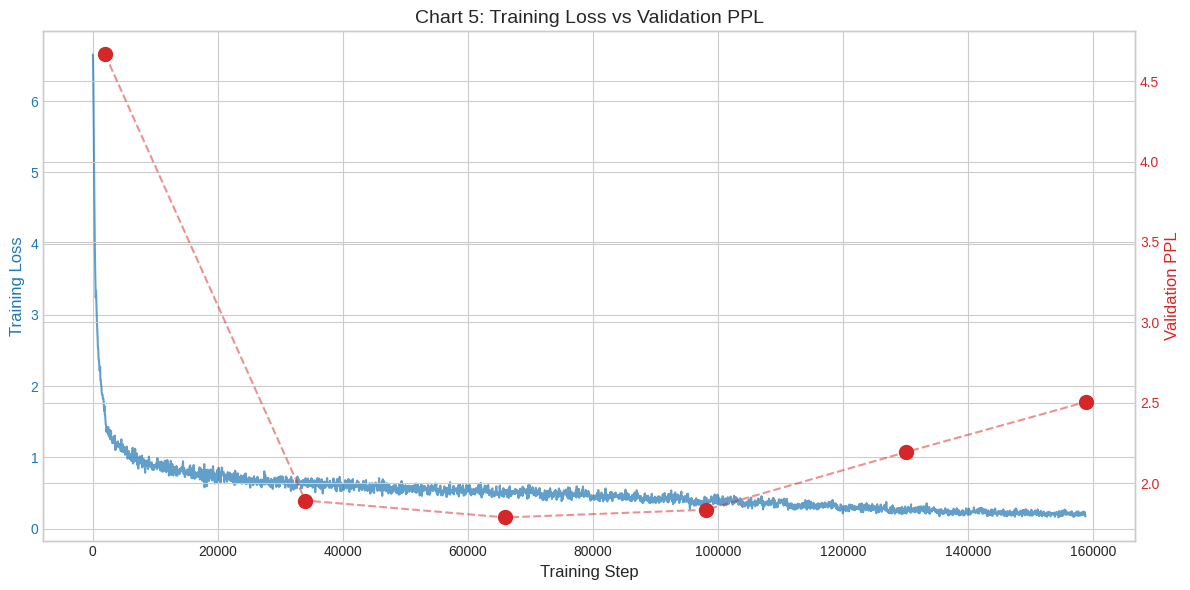

In [17]:
# Chart 5: Training Progress vs Validation PPL
history_path = os.path.join(CONFIG['model_run_path'], 'history.json')

if os.path.exists(history_path):
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Training loss
    color1 = 'tab:blue'
    ax1.plot(history['step'], history['loss'], color=color1, alpha=0.7)
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Training Loss', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # Validation PPL on secondary axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ppl_data = CHECKPOINT_RESULTS.sort_values('step')
    ax2.scatter(ppl_data['step'], ppl_data['perplexity'], 
                color=color2, s=100, zorder=5)
    ax2.plot(ppl_data['step'], ppl_data['perplexity'],
             color=color2, linestyle='--', alpha=0.5)
    ax2.set_ylabel('Validation PPL', color=color2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title('Chart 5: Training Loss vs Validation PPL', fontsize=14)
    fig.tight_layout()
    plt.show()
else:
    print(f"history.json not found at {history_path}")


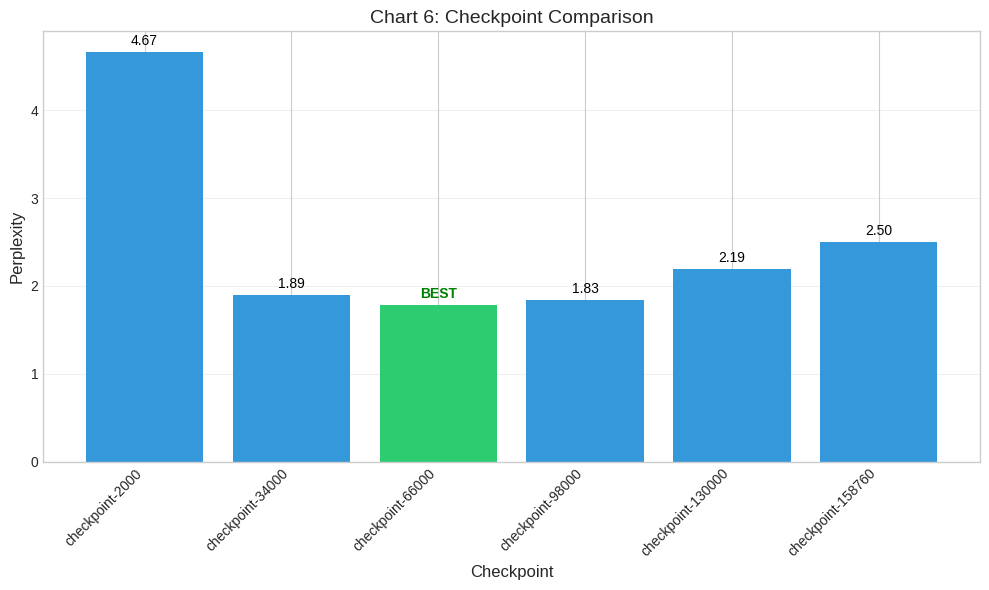

In [18]:
# Chart 6: Checkpoint Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

data = CHECKPOINT_RESULTS.sort_values('step')
colors = ['#2ecc71' if cp == BEST_CHECKPOINT else '#3498db' for cp in data['checkpoint']]
bars = ax.bar(range(len(data)), data['perplexity'], color=colors)

ax.set_xticks(range(len(data)))
ax.set_xticklabels(data['checkpoint'], rotation=45, ha='right')
ax.set_xlabel('Checkpoint', fontsize=12)
ax.set_ylabel('Perplexity', fontsize=12)
ax.set_title('Chart 6: Checkpoint Comparison', fontsize=14)

# Annotate
for idx, (cp, ppl) in enumerate(zip(data['checkpoint'], data['perplexity'])):
    label = 'BEST' if cp == BEST_CHECKPOINT else f'{ppl:.2f}'
    color = 'green' if cp == BEST_CHECKPOINT else 'black'
    weight = 'bold' if cp == BEST_CHECKPOINT else 'normal'
    ax.annotate(label, (idx, ppl), textcoords='offset points', xytext=(0, 5), 
                ha='center', fontweight=weight, color=color)

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## Phase 9: Export Results
Save all results, plots, and generate summary report.

In [20]:
# Create output directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DIR = os.path.join(CONFIG['results_base_dir'], f"{MODEL_INFO['model_name']}_{timestamp}")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'tables'), exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

# Save checkpoint selection results
CHECKPOINT_RESULTS.to_json(os.path.join(OUTPUT_DIR, 'checkpoint_selection.json'), orient='records', indent=2)
CHECKPOINT_RESULTS.to_csv(os.path.join(OUTPUT_DIR, 'tables', 'checkpoint_selection.csv'), index=False)

# Save test results
TEST_RESULTS.to_json(os.path.join(OUTPUT_DIR, 'test_results.json'), orient='records', indent=2)
TEST_RESULTS.to_csv(os.path.join(OUTPUT_DIR, 'tables', 'test_results.csv'), index=False)

# Save config
config_export = {
    'config': CONFIG,
    'model_info': MODEL_INFO,
    'best_checkpoint': BEST_CHECKPOINT,
    'timestamp': timestamp
}
with open(os.path.join(OUTPUT_DIR, 'config.json'), 'w') as f:
    json.dump(config_export, f, indent=2, default=str)

print("Results saved!")


Output directory: ./results/xlstm_lmd_512d_4096ctx_12b_20260208_140021
Results saved!


In [23]:
# Generate summary report
summary = f"""# Perplexity Evaluation Summary

**Model**: {MODEL_INFO['model_name']}
**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M')}

## Model Configuration
- Embedding Dim: {MODEL_INFO['embedding_dim']}
- Num Blocks: {MODEL_INFO['num_blocks']}
- Training Context: {MODEL_INFO['training_context_length']}
- Vocab Size: {MODEL_INFO['vocab_size']}

## Best Checkpoint
- **Checkpoint**: {BEST_CHECKPOINT}
- **PPL at Training Context**: {BEST_PPL:.4f}

## Checkpoint Selection Results
{CHECKPOINT_RESULTS.to_markdown(index=False)}

## Test Results (All Context Lengths)
{TEST_RESULTS.to_markdown(index=False)}
"""

with open(os.path.join(OUTPUT_DIR, 'summary.md'), 'w') as f:
    f.write(summary)

print("Summary saved!")
print(f"\nAll results saved to: {OUTPUT_DIR}")


Summary saved!

All results saved to: ./results/xlstm_lmd_512d_4096ctx_12b_20260208_140021


## Summary

Evaluation complete! Check the output directory for:
- `config.json` - Configuration used
- `validation_results.json/csv` - All validation PPL values
- `test_results.json/csv` - Test PPL values for best checkpoint
- `summary.md` - Human-readable summary
- `plots/` - All visualization charts (if saved)
